In [42]:
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from utils import calc_metrics

In [18]:
X = pd.read_csv('data/x.csv', index_col='date')
y = pd.read_csv('data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

In [19]:
metrics

,accuracy,f1,precision,recall
min_baseline,0.663158,0.667893,0.669919,0.666111


### Мешок слов плюс линейная модель

Создадим функцию для тестирования наших моделей. Зададим начальный порог и будем обучать, модель на наблюдениях до порога, а тестировать на одном наблюдении после. Двигая порог протестируем нашу модель. И потом сравним с истинными ответами. Качество всех наших моделей будем записывать в табличку.

Обучим логистическую регрессию с l1 регуляризацией, она нам покажет какие слова не влияют на предсказание модели.

In [ ]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [21]:
auc = []
for c in tqdm(np.linspace(0.001, 10, 30)):
    auc.append(calc_metrics(bow, y, LogisticRegression, name='bow l1 only release', plot=False, solver='liblinear', penalty='l1', C=c.item()))

roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/30 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 30/30 [00:12<00:00,  2.37it/s]

Лучшая модель - LogisticRegression(C=6.896862068965518, penalty='l1', solver='liblinear')
ROC-AUC = 0.7685703515913654


Рассмотрим подробнее лучшую модель.

              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.50      0.58      0.54        24
         1.0       0.73      0.58      0.65        19

    accuracy                           0.62        66
   macro avg       0.64      0.62      0.63        66
weighted avg       0.64      0.62      0.62        66



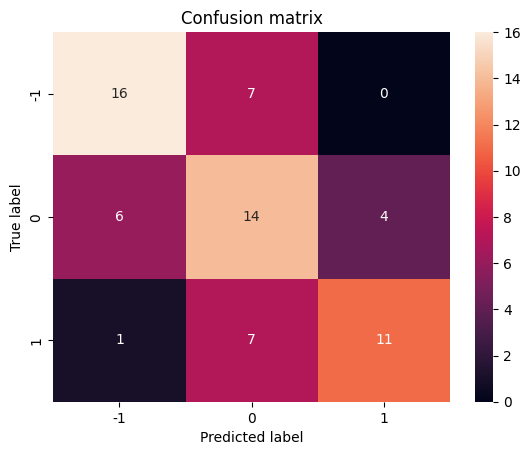

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.76552


In [23]:
metric, model = calc_metrics(bow, y, LogisticRegression, name='bow l1 only release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество даже хуже минимального бейзлайна, подберем гиперпараметры для elasticnet, и только на тех словах, веса при которых не занулила прошлая модель. Мы таким образом заглянем в тестовую выборку, но скорее всего это будет не критично. Таким образом расширим множество стоп слов, словами которые не важны для прошлой модели.

In [24]:
STOP_WORDS |= set(vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)])

In [25]:
vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [27]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                bow, y, 
                LogisticRegression,
                name='bow l2', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [01:52<00:00, 28.07s/it]

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8741327350998742


Обучим лучшую модель и посмотрим ее оценки качества подробнее.

              precision    recall  f1-score   support

        -1.0       0.82      0.78      0.80        23
         0.0       0.61      0.71      0.65        24
         1.0       0.75      0.63      0.69        19

    accuracy                           0.71        66
   macro avg       0.73      0.71      0.71        66
weighted avg       0.72      0.71      0.71        66



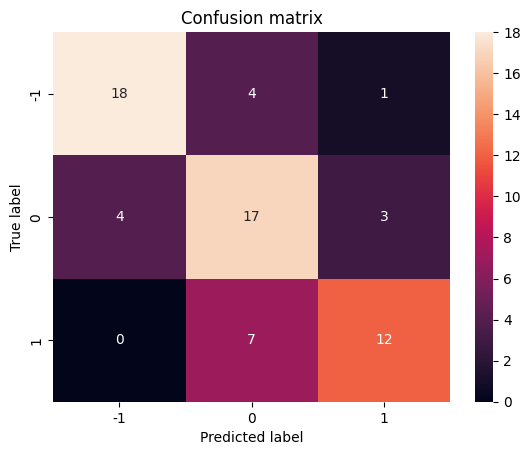

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.765520
bow elasticnet,0.712121,0.713187,0.725108,0.707507,0.875541


In [29]:
metric, _ = calc_metrics(bow, y, LogisticRegression, name='bow elasticnet', **best_model.get_params())
metrics = pd.concat((metrics, metric))
metrics

Качество немного подросло попробуем обучить мешок слов не только на пресс-релизах, но и на названиях.

In [30]:
vectorizer_title = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

bow_title = vectorizer_title.transform(X.title)

In [31]:
bow_title_release = np.concatenate((bow.toarray(), bow_title.toarray()), axis=1)

Подберем гиперпараметры для модели обучаемой на названии релиза и самом релизе.

In [32]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                bow_title_release, y,
                LogisticRegression, 
                name='bow', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [01:49<00:00, 27.38s/it]

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8748792823189858


Посмотрим на метрики модели и добавим их в таблицу.

              precision    recall  f1-score   support

        -1.0       0.82      0.78      0.80        23
         0.0       0.61      0.71      0.65        24
         1.0       0.75      0.63      0.69        19

    accuracy                           0.71        66
   macro avg       0.73      0.71      0.71        66
weighted avg       0.72      0.71      0.71        66



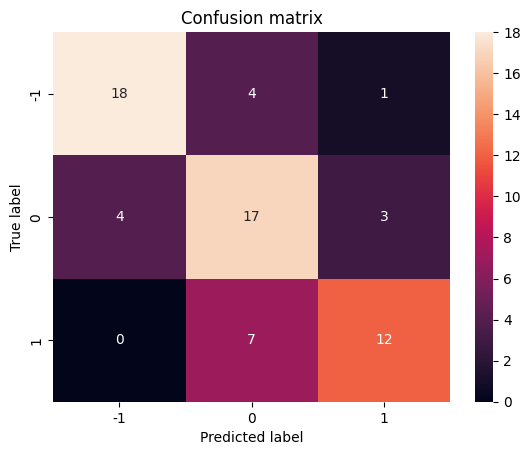

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.765520
bow elasticnet,0.712121,0.713187,0.725108,0.707507,0.875541
bow release title,0.712121,0.713187,0.725108,0.707507,0.874175


In [34]:
metric, _ = calc_metrics(
    bow_title_release, y, 
    LogisticRegression, 
    name='bow release title', 
    **best_model.get_params()
)
metrics = pd.concat([metrics, metric])
metrics

Добавление мешка слов по названию не улучшило нашу модель, а только усложнило ее. Попробуем к мешку слов по текстам релизов, с самыми важными словами добавим количественные признаки.

In [36]:
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

In [37]:
all_data = np.concatenate((bow_title_release, X[num_columns].values), axis=1)

In [38]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                all_data, y,
                LogisticRegression,
                name='bow all data', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
                )
            )
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [01:50<00:00, 27.64s/it]

Лучшая модель - LogisticRegression(C=5, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.865550140596012


              precision    recall  f1-score   support

        -1.0       0.79      0.83      0.81        23
         0.0       0.62      0.67      0.64        24
         1.0       0.75      0.63      0.69        19

    accuracy                           0.71        66
   macro avg       0.72      0.71      0.71        66
weighted avg       0.72      0.71      0.71        66



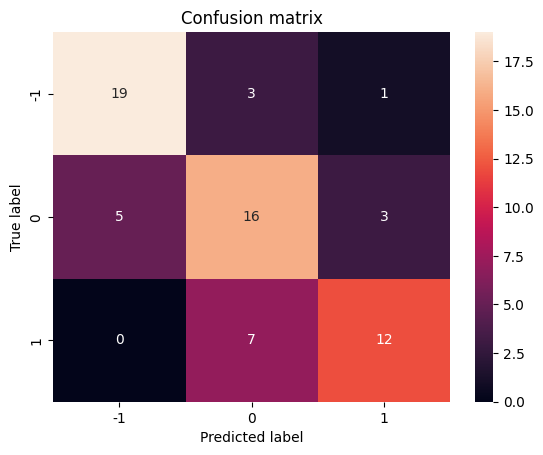

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.765520
bow elasticnet,0.712121,0.713187,0.725108,0.707507,0.875541
bow release title,0.712121,0.713187,0.725108,0.707507,0.874175
bow release all num,0.712121,0.711408,0.719017,0.708111,0.863445


In [40]:
metric, _ = calc_metrics(
    all_data, y, 
    LogisticRegression, 
    name='bow release all num', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Добавление количественных переменных только ухудшило нашу модель. Попробуем на мешке слов обученный на релизах обучить SVC.

In [ ]:
auc = []
for c in tqdm([0.01, 0.05, 0.1, 0.5, 1, 3, 5, 7, 10]):
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        auc.append(
            calc_metrics(
                bow, y,
                SVC,
                name='bow svc only release', 
                kernel=kernel,
                C=c,
                plot=False, 
                probability=True,
                )
            )
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/9 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

Лучшая модель - SVC(C=3, kernel='linear', probability=True)
ROC-AUC = 0.8432641740883605


              precision    recall  f1-score   support

        -1.0       0.76      0.70      0.73        23
         0.0       0.57      0.67      0.62        24
         1.0       0.76      0.68      0.72        19

    accuracy                           0.68        66
   macro avg       0.70      0.68      0.69        66
weighted avg       0.69      0.68      0.69        66



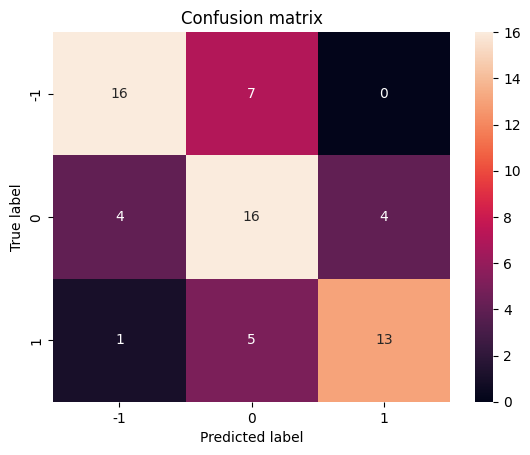

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.765520
bow elasticnet,0.712121,0.713187,0.725108,0.707507,0.875541
bow release title,0.712121,0.713187,0.725108,0.707507,0.874175
bow release all num,0.712121,0.711408,0.719017,0.708111,0.863445
bow svc only release,0.681818,0.688293,0.699346,0.682176,0.838719


In [47]:
metric, _ = calc_metrics(
    bow, y, 
    SVC, 
    name='bow svc only release', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Метод опорных векторов показал качество хуже чем логистическая регрессия.